<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_11_Project_3_Option_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Missing Values in Wine Dataset

Take the wine dataset, randomly convert 10 values from residual sugar into NaN values, and then use it to train a model to predict the missing values. Finally, compare the values with the true ones using MSE and especially correlation. This is Mike's Version

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import copy

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## High-Quality Figures
from IPython import display
display.set_matplotlib_formats("svg")

In [2]:
# We will use the Wine dataset.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

# Normalize all features
data = (data - data.mean())/data.std(ddof=1)

# create a deep copy of the data to modify
original_data = copy.deepcopy(data)

## Replace some elements with NaNs

In [3]:
# Number of missing data points
n2nan = 10

# Pick n-random rows and set them to nan
whichVals2nan = np.random.choice(range(len(data)), size=n2nan)

# Set those values to NaN
data["residual sugar"][whichVals2nan] = np.nan

# Get a vector of real-valued rows
whichValNotNan = np.where(~data["residual sugar"].isna())[0]

# confirm the whole thing
print(np.sort(whichVals2nan))
print(np.where(data["residual sugar"].isna())[0])

[  90  208  309  366  575  721 1199 1296 1496 1497]
[  90  208  309  366  575  721 1199 1296 1496 1497]


## Split into Train/Test and COnvert to DataLoader

In [4]:
# drop residual sugar column for trianing data
cols2keep = data.keys().drop("residual sugar")

# Train Tensor
train_dataT = torch.tensor(data[cols2keep].values).float()
train_dataT = train_dataT[whichValNotNan,:]
train_labelsT = torch.tensor(data["residual sugar"].values).float()
train_labelsT = train_labelsT[whichValNotNan, None]

# Test Tensor
test_dataT = torch.tensor(original_data[cols2keep].values).float()
test_dataT = test_dataT[whichVals2nan,:]
test_labelsT = torch.tensor(original_data["residual sugar"].values).float()
test_labelsT = test_labelsT[whichVals2nan,None]

# Conform the sizes
print(f"Original Data: {data.shape}\n")
print(f"Train Data: {train_dataT.shape}\n")
print(f"Train Labels: {train_labelsT}\n")
print(f"Test Labels: {test_labelsT}\n")

Original Data: (1599, 12)

Train Data: torch.Size([1589, 11])

Train Labels: tensor([[-0.4531],
        [ 0.0434],
        [-0.1694],
        ...,
        [-0.1694],
        [-0.3822],
        [ 0.7527]])

Test Labels: tensor([[-0.1694],
        [ 2.3130],
        [-0.1694],
        [-0.4531],
        [-0.5949],
        [-0.4531],
        [ 0.2207],
        [ 0.1143],
        [ 0.3980],
        [ 1.2491]])



In [5]:
# Convert into PyTorch Dataset
train_data = TensorDataset(train_dataT, train_labelsT)

# TRanslate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
# No need for test_loader. Tensor is OK

## Model Architecture

In [6]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(11,16)

        # Define two hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        # Define the output layer
        self.output = nn.Linear(32,1)

    # Forwad Pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [7]:
# Train the Model
numepochs = 400

def trainTheModel():

    winenet = ANNwine()

    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(winenet.parameters(), lr=0.01)

    trainLoss = torch.zeros(numepochs)

    for epochi in range(numepochs):

        batchLoss = []

        for X,y in train_loader:

            # forward pass and losses
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
        
        # End of batch loop

        # Average losses accross the batches
        trainLoss[epochi] = np.mean(batchLoss)

    return winenet, trainLoss

In [8]:
winenet, trainLoss = trainTheModel()

In [9]:
yHatTrain = winenet(train_dataT)
yHatTest = winenet(test_dataT)

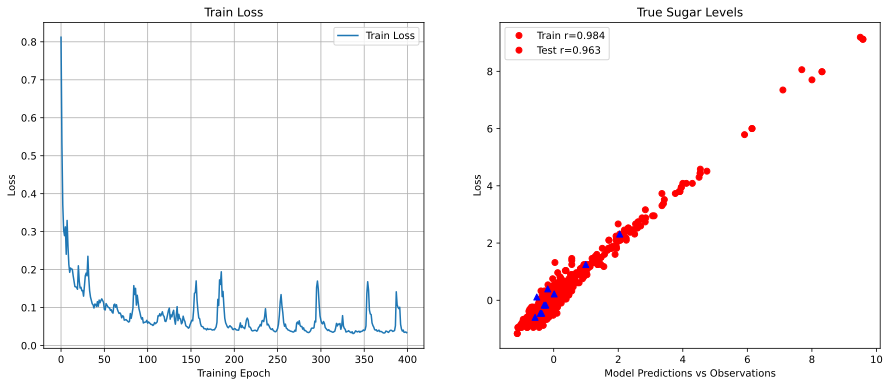

In [10]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].plot(trainLoss, label="Train Loss")
ax[0].set_title("Train Loss")
ax[0].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid()

ax[1].plot(yHatTrain.detach().T, train_labelsT.T, "ro")
ax[1].plot(yHatTest.detach().T, test_labelsT.T, "b^")
ax[1].set_title("True Sugar Levels")
ax[1].set_xlabel("Model Predictions vs Observations")
ax[1].set_ylabel("Loss")

corrTrain = np.corrcoef(yHatTrain.detach().T, train_labelsT.T)[1,0]
corrTest = np.corrcoef(yHatTest.detach().T, test_labelsT.T)[1,0]
ax[1].legend([f"Train r={corrTrain:.3f}", f"Test r={corrTest:.3f}"])

plt.show()